
# Hindi MNIST Computer Vision Classifier



#### The notebok is based on FastAI course that ran in April to May 2022; it is written to explore the "further research" questions of lesson 3 of the course, which deals with Neural Net foundations.



> ### ***Problem statement*** - Classify the hand written digits with the help of FastAI's libraries


> ### ***Data*** - Hindi MNIST data present at https://www.kaggle.com/datasets/anurags397/hindi-mnist-data

> ### The ***Methodology*** will remain the same as discussed in the chapter.
> - Define the baseline model first.
> - Define dataloaders and other parameters that are required for implementing the ***Stochastic Gradient Descent***, 
> - Define the loss function and the accuracy metric
> - Fit your model using FastAI's libraries and check whether it beats the baseline model.
> - Make Improvements.


> ### ***Resources:*** 
> - Chapter Link: https://course.fast.ai/Lessons/lesson3.html
> - Video based on 2020 course where the part of the problem is discussed: https://www.youtube.com/watch?v=p50s63nPq9I&t=6605s



# Imports and Downloads

In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
!pip install fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.3.0
    Uninstalling typing_extensions-4.3.0:
      Successfully uninstalled typing_extensions-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.

In [2]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Read the Data

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    cnt = 0
    for filename in filenames:
        cnt = cnt+1
        #print(os.path.join(dirname, filename))
    print(f"Read {cnt} files from the directory- {dirname}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Read 0 files from the directory- /kaggle/input
Read 0 files from the directory- /kaggle/input/hindi-mnist
Read 0 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST
Read 0 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/7
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/2
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/5
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/8
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/0
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/3
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/1
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/4
Read 300 files from the directory- /kaggle/input/hindi-mnist/Hindi-MNIST/test/9
Read 300 files from the dir

### Define train and validation paths

In [4]:
train_dir = "/kaggle/input/hindi-mnist/Hindi-MNIST/train"
train_path = Path(train_dir)
valid_dir = "/kaggle/input/hindi-mnist/Hindi-MNIST/test"
valid_path = Path(valid_dir)

In [5]:

zeroes = train_path.ls().sorted()[0].ls()
ones = train_path.ls().sorted()[1].ls()
twos = train_path.ls().sorted()[2].ls()
threes = train_path.ls().sorted()[3].ls()
fours = train_path.ls().sorted()[4].ls()
fives = train_path.ls().sorted()[5].ls()
sixes = train_path.ls().sorted()[6].ls()
sevens = train_path.ls().sorted()[7].ls()
eights = train_path.ls().sorted()[8].ls()
nines = train_path.ls().sorted()[9].ls()    

### Print a digit to see what the data is

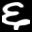

In [6]:
im = Image.open(sixes[0])
im

In [7]:
tensor(im)[4:10,4:10]

tensor([[  4,  28,  97, 185, 236, 254],
        [ 50, 164, 245, 255, 255, 255],
        [184, 251, 255, 255, 254, 236],
        [253, 255, 255, 253, 191,  79],
        [255, 255, 255, 190,  54,   7],
        [255, 255, 254, 139,  22,   1]], dtype=torch.uint8)

In [8]:
im.shape

(32, 32)

 The size of the images  - 32 x 32

#### Pandas has a nice background gradient feature

In [9]:
im_t = tensor(im)
df = pd.DataFrame(im_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,4,28,97,185,236,254,255,255,255,255,255,255,255,255,255,255,255,233
1,50,164,245,255,255,255,255,252,234,208,181,159,154,183,235,254,255,255
2,184,251,255,255,254,236,177,107,56,29,17,11,10,21,75,185,245,254
3,253,255,255,253,191,79,23,6,1,0,0,0,0,0,7,40,98,130
4,255,255,255,190,54,7,0,0,0,0,0,0,0,0,0,1,4,6
5,255,255,254,139,22,1,0,0,0,0,0,0,0,0,0,0,0,0
6,255,255,255,213,87,25,10,5,3,4,7,8,7,4,2,0,0,0
7,248,255,255,255,239,195,156,128,111,117,138,150,140,98,42,9,1,0
8,161,245,255,255,255,255,255,254,252,253,255,255,254,247,154,34,3,0
9,45,143,245,255,255,255,255,255,255,255,255,255,255,250,149,32,2,0


# Baseline Model
> #### Create a model that is simple and works fine enough(ideally, it should beat the chance i.e. it should have at least 50% accurate)

### Distance from mean - Create a mean image for each of the digit from 0 to 9

In [10]:
Dict = {0: zeroes,1:ones, 2: twos, 3: threes, 4: fours, 5: fives, 6: sixes, 7:sevens, 8:eights, 9:nines}

In [11]:
train_tensors = []
valid_tensors = []

for key in Dict:
    train_tensors.append([tensor(Image.open(o)) for o in Dict[key]])
    valid_inf =  valid_path.ls().sorted()[key].ls()
    valid_tensors.append([tensor(Image.open(o)) for o in valid_inf])
    

#### Keep checking the size of the variables involved, it is one of the best practices

In [12]:
len(train_tensors), len(valid_tensors), len(train_tensors[0]), len(valid_tensors[0])


(10, 10, 1700, 300)

### Stack the images for each of the digit class and find the mean digit(average of all the images for a digit)

>  #### ***Each image is 2D with size 32*32, by stacking all 1700 images(for one digit) in the train set, we create a 3d shape of 1700*32*32

In [13]:
stacked_train_tensors = []
for i in range(len(train_tensors)):
    stacked_train_tensors.append((torch.stack(train_tensors[i]).float()/255))
    #print(i)
                                 
print(len(stacked_train_tensors)), print(stacked_train_tensors[0].shape)                                

10
torch.Size([1700, 32, 32])


(None, None)

In [14]:
stacked_train_tensors_mean = []
for i in range(len(train_tensors)):
    stacked_train_tensors_mean.append((torch.stack(train_tensors[i]).float()/255).mean(0))
    #print(i)
print(len(stacked_train_tensors_mean))

10


In [15]:
stacked_valid_tensors = []
for i in range(len(valid_tensors)):
    stacked_valid_tensors.append((torch.stack(valid_tensors[i]).float()/255))
    #print(i)
print(len(stacked_valid_tensors)), print(stacked_valid_tensors[0].shape)

10
torch.Size([300, 32, 32])


(None, None)

In [16]:
stacked_train_tensors_mean[0].shape

torch.Size([32, 32])

### Plot one of the mean images, it will be blurry as it is a mean value

<AxesSubplot:>

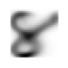

In [17]:
show_image(stacked_train_tensors_mean[4])

<AxesSubplot:>

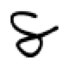

In [18]:
# Print a random digit
show_image(train_tensors[4][0])

### Take a sample image and fine the distance between the image from its respective mean image i.e. compare a 4 with the mean 4.
### Here, Root mean square and mean absolute errors are calculated

In [19]:
dist_4_abs = (train_tensors[4][0] - stacked_train_tensors_mean[4]).abs().mean()
dist_4_sqr = ((train_tensors[4][0] - stacked_train_tensors_mean[4])**2).mean().sqrt()

dist_4_abs, dist_4_sqr

(tensor(49.9770), tensor(104.4630))

In [20]:
dist_3_abs = (train_tensors[3][0] - stacked_train_tensors_mean[4]).abs().mean()
dist_3_sqr = ((train_tensors[3][0] - stacked_train_tensors_mean[4])**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(67.0818), tensor(122.1938))

### The error checks out i.e. the distance between mean 4 and 4 is less than mean 4 and 3(or any other number). Let's investigate it more

### Let's define Error functions

In [21]:
def rms_error(a,b):
    return ((a-b)**2).mean((-1, -2)).sqrt()
    

#### RMS error

In [22]:
for i in range(10):
    err =  rms_error(train_tensors[4][0],stacked_train_tensors_mean[i])
    print(err)
        

tensor(104.5548)
tensor(104.4847)
tensor(104.5112)
tensor(104.4911)
tensor(104.4630)
tensor(104.4989)
tensor(104.5112)
tensor(104.4960)
tensor(104.5195)
tensor(104.4974)


### L1 error

In [23]:

for i in range(10):
    print(F.l1_loss(train_tensors[4][0].float(),stacked_train_tensors_mean[i]))

tensor(50.0465)
tensor(50.0393)
tensor(50.0182)
tensor(50.0276)
tensor(49.9770)
tensor(50.0150)
tensor(50.0189)
tensor(50.0297)
tensor(50.0313)
tensor(50.0543)


### MSE/L2 error

In [24]:
for i in range(10):
    print(F.mse_loss(train_tensors[4][0].float(),stacked_train_tensors_mean[i]))

tensor(10931.7139)
tensor(10917.0586)
tensor(10922.5928)
tensor(10918.3809)
tensor(10912.5215)
tensor(10920.0205)
tensor(10922.5967)
tensor(10919.4229)
tensor(10924.3340)
tensor(10919.7129)


>  ### _All the error functions have lowest error values for the distance between mean digits and sample image - train_tensors[4][0] which is a 4_

### Broadcasting happens here, despite different shapes of the two tensors, the results are calculated

### All tensors in the validation set for a particular digit will be compared against the mean digit

In [25]:


print(stacked_valid_tensors[4].shape), print(stacked_train_tensors_mean[4].shape)
error = rms_error(stacked_valid_tensors[4], stacked_train_tensors_mean[4])
error.shape, error[0:15]

torch.Size([300, 32, 32])
torch.Size([32, 32])


(torch.Size([300]),
 tensor([0.3021, 0.3300, 0.2755, 0.2987, 0.3047, 0.3128, 0.3670, 0.3253, 0.3164, 0.3172, 0.3009, 0.3079, 0.3204, 0.2997, 0.2655]))

In [26]:

def predict_input(input_tensor):
    errors_in_pred = []
   # errors = rms_error(input_tensor, stacked_train_tensors_mean[x])
    for i in range(10):
        errors = rms_error(input_tensor, stacked_train_tensors_mean[i])
        errors_in_pred.append(errors)
    #return torch.argmin(torch.stack(errors_in_pred), 0)
    # across the first axis, 0 specifies the axis
    return torch.argmin(torch.stack(errors_in_pred), 0)

In [27]:
y = predict_input(stacked_valid_tensors[9])
y, y.shape

(tensor([9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 1, 9, 0, 9, 9, 9, 6, 9, 9, 9, 9, 9, 9, 8, 9, 9, 9,
         9, 9, 9, 9, 8, 9, 9, 9, 9, 9, 9, 6, 6, 9, 9, 9, 9, 9, 9, 9, 6, 9, 9, 9, 1, 9, 9, 9, 9, 9, 8, 9, 9, 6, 9, 9, 9, 9, 9, 9, 1, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 1, 9,
         9, 9, 9, 1, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 2, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
         9, 6, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 9, 9, 9, 1, 9, 9, 9, 9,
         6, 8, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 1, 9]),
 torch.Size([300]))

In [28]:
(y == 9).float().mean()

tensor(0.8833)

In [29]:
accuracies = []
for i in range(10):
    #print(i)
    preds = predict_input(stacked_valid_tensors[i])
    acc = (preds == i).float().mean()
    accuracies.append(acc)
    #print(preds)
    #pred_e = torch.argmin(err, 0) 
   # print(preds)
    #accuracies.append((pred_e == i).float().mean())
    
accuracies

[tensor(0.9667),
 tensor(0.9033),
 tensor(0.7300),
 tensor(0.5867),
 tensor(0.9267),
 tensor(0.7433),
 tensor(0.8567),
 tensor(0.7900),
 tensor(0.8767),
 tensor(0.8833)]

In [30]:
print('baseline model accuracy:', torch.stack(accuracies).mean())

baseline model accuracy: tensor(0.8263)


### 82% baseline accuracy, let's try to beat that

# Prepare for Stochastic gradient descent

In [31]:
stacked_train_tensors[0][0].shape # one image from digit 0

torch.Size([32, 32])

### Entire data in row column format

In [32]:
lst = [stacked_train_tensors[i] for i in range(10)]
# one row represents one image. image is flattened to 32*32 = 1024 pixels
train_x = torch.cat(lst).view(-1, 32*32) 
train_x.shape

torch.Size([17000, 1024])

In [33]:
#train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
y_tensor = torch.tensor([])
for i in range(10):
    a = tensor(np.full(len(stacked_train_tensors[i]),i))
    y_tensor = torch.cat([y_tensor, a])    
    
y_tensor = y_tensor.unsqueeze(1)  

#### PyTorch won't accept a FloatTensor as categorical target, so you've to cast your tensor to LongTensor

In [34]:
y_tensor


tensor([[0.],
        [0.],
        [0.],
        ...,
        [9.],
        [9.],
        [9.]])

In [35]:
y_tensor = y_tensor.type(torch.LongTensor)

In [36]:
y_tensor.shape

torch.Size([17000, 1])

### This is an important step, it will create tuples of input and output

In [37]:
dset = list(zip(train_x,y_tensor))

### Same processing for validation set

In [38]:
valid_lst = [stacked_valid_tensors[i] for i in range(10)]
# one row represents one image. image is flattened to 32*32 = 1024 pixels
valid_x = torch.cat(valid_lst).view(-1, 32*32) 
valid_x.shape


#train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
valid_y_tensor = torch.tensor([])
for i in range(10):
    a = tensor(np.full(len(stacked_valid_tensors[i]),i))
    valid_y_tensor = torch.cat([valid_y_tensor, a])    
    
valid_y_tensor = valid_y_tensor.unsqueeze(1) 

valid_dset = list(zip(valid_x,valid_y_tensor))

In [39]:
valid_y_tensor.shape

torch.Size([3000, 1])

> ## Testing a few things, ignore

In [40]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

weights = init_params((32*32,1))
bias = init_params(1)


In [41]:
weights.shape, bias.shape

(torch.Size([1024, 1]), torch.Size([1]))

In [42]:
# Prediction for one image

(train_x[0]*weights.T).sum() + bias


tensor([14.7308], grad_fn=<AddBackward0>)

In [43]:
# @ is for matrix multiplication 
def linear1(xb): 
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[ 14.7308],
        [ 15.2412],
        [ 12.4542],
        ...,
        [  7.2494],
        [-17.0967],
        [  6.3935]], grad_fn=<AddBackward0>)

In [44]:
train_x.shape

torch.Size([17000, 1024])

In [45]:
preds.shape

torch.Size([17000, 1])

> ## Testing ends here

# Let's build the Neural Net model

## Dataloaders

In [46]:
dl_train = DataLoader(dset, batch_size=256, shuffle=True)
dl_valid = DataLoader(valid_dset, batch_size=256)

In [47]:
dls = DataLoaders(dl_train, dl_valid)


#### 17000 train samples divided in 256 batches 17000/256 ~ 67

In [48]:
len(dls.train)


67

## Loss functions and Accuracy metric

### Sigmoid transforms everything between 0 and 1, helps in taking probability

In [49]:
def loss_func(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [50]:
def accuracy_metric(prediction, y):
    idx = torch.argmax(prediction, axis=1) # returns the index of the highest value
    return (idx==y.T).float().mean()

### Define the model. we'll use 30 neurons in the hidden layer. 1024 in input, 30 in hidden, 10 in output(because 10 classes are there (0 to 9))

In [51]:
model = nn.Sequential(
    nn.Linear(32*32, 30), # 1024 input features and 30 output features
    nn.ReLU(),
    nn.Linear(30,10),
)


In [52]:
learn_loss_func = Learner(dls, model, loss_func=loss_func, opt_func=SGD, metrics=accuracy_metric)


In [53]:
learn_loss_func.fit(n_epoch=10, lr=0.1)


epoch,train_loss,valid_loss,accuracy_metric,time
0,0.214083,0.123915,0.091667,00:00
1,0.133767,0.108301,0.091000,00:00
2,0.113340,0.104889,0.090667,00:00
3,0.108106,0.103433,0.090667,00:00
4,0.103318,0.102633,0.090333,00:00
5,0.102949,0.102128,0.089667,00:00
6,0.102660,0.101779,0.090667,00:00
7,0.102763,0.101527,0.092333,00:00
8,0.102156,0.101335,0.095333,00:00
9,0.101422,0.101184,0.097000,00:00


> #### _This model didn't learn or what?_

In [54]:
def softmax_loss(prediction, y):
    soft_m = torch.softmax(prediction, dim=1)
    index = tensor(range(len(y)))
    return soft_m[index.long(), y.long()].mean()

In [55]:
learn_softmax = Learner(dls, model, loss_func=softmax_loss, opt_func=SGD, metrics=accuracy_metric)


In [56]:
learn_softmax.fit(n_epoch=10, lr=0.1)


epoch,train_loss,valid_loss,accuracy_metric,time
0,0.100436,0.099736,0.098333,00:00
1,0.100521,0.099690,0.096000,00:00
2,0.100557,0.099638,0.100000,00:00
3,0.100653,0.099551,0.098667,00:00
4,0.100606,0.099459,0.100667,00:00
5,0.100483,0.099377,0.100333,00:00
6,0.100640,0.099186,0.099333,00:00
7,0.100577,0.099071,0.099000,00:00
8,0.100639,0.098888,0.097000,00:00
9,0.100628,0.098917,0.096333,00:00


> #### _This doesn't work as well, it's not learning._

### _I cheated and looked on forums and people said there can be precision issues, so use something logarithmic_

In [57]:
def loss_entropy(pred, y):
    #print(y.shape)
    y = y.long()
    if y.ndim > 1:
        y = y.squeeze()
   # print(y.shape)
    return F.cross_entropy(pred, y)


In [58]:
learn_entropy = Learner(dls, model, loss_func=loss_entropy, opt_func=SGD, metrics=accuracy_metric)


In [59]:
learn_entropy.fit(n_epoch=30, lr=0.1)


epoch,train_loss,valid_loss,accuracy_metric,time
0,0.989585,0.521992,0.858000,00:00
1,0.518371,0.347884,0.895667,00:00
2,0.346704,0.284983,0.909667,00:00
3,0.272468,0.256439,0.920333,00:00
4,0.230199,0.212597,0.945333,00:00
5,0.207443,0.198280,0.949000,00:00
6,0.190783,0.185562,0.947667,00:00
7,0.174779,0.179351,0.951333,00:00
8,0.163493,0.172312,0.955000,00:00
9,0.155247,0.166811,0.956000,00:00


> ### _It learns now_

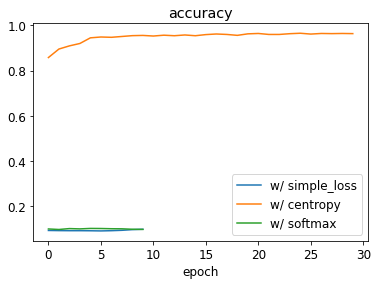

In [60]:
plt.plot(L(learn_loss_func.recorder.values).itemgot(2), label='w/ simple_loss');
plt.plot(L(learn_entropy.recorder.values).itemgot(2), label='w/ centropy');
plt.plot(L(learn_softmax.recorder.values).itemgot(2), label='w/ softmax');

plt.title('accuracy');
plt.legend(loc='best');
plt.xlabel('epoch');

# The FastAI model has beaten the baseline model.
#### Although, I am still not very sure why the softmax or simple loss didn't work 

> #### Just checking what's happening inside the model. 

In [61]:
y_tensor[10000:10010]

tensor([[5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5],
        [5]])

> #### The index corresponding to y_tensor value will have ideally highest value in the predictions.

In [62]:
model(train_x)[10000:10010]

tensor([[-12.5915,  -5.5043,  -8.8870,  -3.4508,  -3.3452,   5.5960,  -1.0710,  -1.8192, -10.9644, -10.7473],
        [-18.2513, -23.7355,  -2.3928,  -1.6395,  -5.8924,   5.2856, -11.4164,  -9.5124,  -9.5765, -15.0326],
        [-19.6813, -13.3664,   0.4013,   0.3663,  -1.9135,   8.4236,   0.1444,  -0.3372, -20.2419, -11.6217],
        [ -9.4473,  -9.3769,  -1.5958,  -1.1041,  -5.1527,   3.5932,  -4.2382,  -3.6048,  -5.3509, -12.6652],
        [-15.1676,  -7.6468,  -1.3655,  -4.8876,  -5.6747,   5.9361,  -6.5804,  -2.6483,  -7.4650, -12.2578],
        [ -8.7004,  -6.9439,  -2.0877,  -1.5366,  -2.4985,   2.0714,  -7.3040,  -7.5453,  -5.1091,  -2.5851],
        [ -9.2084,  -6.5548,  -2.2084,  -0.6765,   0.5429,   5.1066,  -5.8337,  -5.4852,  -6.9861,  -5.3916],
        [-18.3216,  -9.8647,  -0.6680,  -2.3356,  -5.4501,   6.5298,  -3.1101,  -2.1203, -12.1218, -13.7853],
        [ -7.9667, -18.4219,  -8.8755,  -7.8094,  -1.1771,   2.8631,  -9.9230,  -2.7488,  -3.8866, -11.4819],
        [-

In [63]:
m = learn_entropy.model
m

Sequential(
  (0): Linear(in_features=1024, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
)

In [64]:
w, b = m[0].parameters()

### The first layer learns about specific features and patterns from the data but here I am not sure what is being learnt. Maybe computer knows it better

/opt/conda/lib/python3.7/site-packages/fastai/torch_core.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if ax is None: _,ax = plt.subplots(figsize=figsize)


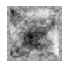

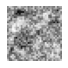

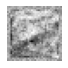

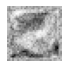

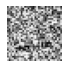

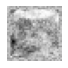

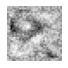

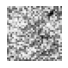

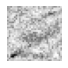

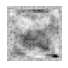

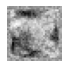

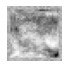

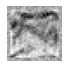

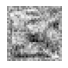

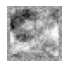

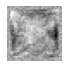

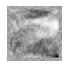

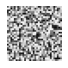

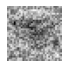

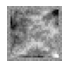

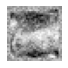

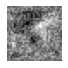

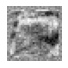

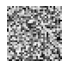

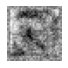

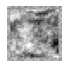

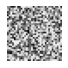

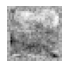

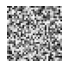

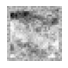

In [65]:
for i in range(w.shape[0]):
    show_image(w[i].view(32,32))


# End of the notebook